In [1]:
import math
import matplotlib.pyplot as plt
import random
import time
import copy
import heapq

In [47]:
def intertwine_heap_list(heap, _list):
    for x in _list:
        heapq.heappush(heap, x)

def get_some_randomness(l, r, elems):
    indexes=list(range(l, r))
    random.shuffle(indexes)
    return indexes[:elems]

class Vertex:
    def __init__(self, v, preve=-1, nexte=-1):
        self.value=v
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def exchange(self, preve, nexte):
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
            
    def check_consistency(self, vertexes):
        if not self.present:
            return
        if not vertexes[self.prev].next==self.value or not vertexes[self.next].prev==self.value:
            print(f"DUPA {self.value}")
    
    def __str__(self):
        return f'{self.value}: <{self.prev}, {self.next}>'
        
class Pathway:
    def _greedy_closest_neigh_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]<self.matrix[last][cur]:
            return True
        return False
    
    def _greedy_cycle_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]+self.matrix[start][compared]<self.matrix[last][cur]+self.matrix[start][cur]:
            return True
        return False

    def _get_maxes(self, v1, v2):
        if self._maxes[0]['place']==v1 or self._maxes[0]['place']==v2:
            if self._maxes[1]['place']==v1 or self._maxes[1]['place']==v2:
                return self._maxes[2]
            return self._maxes[1]
        return self._maxes[0]
    
    def _formulate_maxes(self):
        maxes=[]
        for x in self.vertexes:
            if x.present==False:
                continue
            maxes.append({'value':self.matrix[x.prev][x.value]+self.matrix[x.value][x.next]-self.matrix[x.prev][x.next], 'place':x.value})
        self._maxes=sorted(maxes, key=lambda x: x['value'], reverse=True)[:3]
        
    def _formulate_best(self):
        lst=[]
        for x in self.matrix:
            lst.append([y[0] for y in sorted(list(enumerate(x)), key=lambda x:x[1])[1:6]])
        self.closer=lst
            
    def _double_regret(self, pathway, j, k=2, cnst=1):
        regrets=[]
        ln=len(pathway)
        for i in range(0, ln):
            v1=pathway[i]
            v2=pathway[(i+1)%ln]
            regrets.append((self.matrix[v1][j]+self.matrix[v2][j]-self.matrix[v1][v2], i))
        regrets=sorted(regrets, key=lambda x: x[0])

        sum_of_regrets=-cnst*regrets[0][0]#-regrets[0][0]
        for i in range(1, min(ln, k)):
            sum_of_regrets=sum_of_regrets+regrets[i][0]-regrets[0][0]
        return sum_of_regrets, regrets[0][1]+1


    def _general_heuristic(self, start, comparer, regrets=False, k_reg=2, cnst=1):
        ln=len(self.matrix)//2
        allez=len(self.matrix)
        last, elems, cur, path, devoured=start, 1, -1, [start], [0]*allez
        devoured[start]=1
        fortress_of_regrets=[0, -1]

        while len(path)<ln:
            for j in range(allez):
                if devoured[j]==1:
                    continue

                if regrets==True:
                    partial_regret=comparer(path, j, k_reg, cnst)
                    if cur==-1 or partial_regret[0]>fortress_of_regrets[0]:
                        fortress_of_regrets=partial_regret
                        cur=j
                if regrets==False and (cur==-1 or comparer(last, path[0], cur, j)):
                    cur=j

            last, cur=cur, -1
            devoured[last]=1
            if regrets==False:
                path.append(last)
            else:
                path.insert(fortress_of_regrets[1], last)
            fortress_of_regrets=[0, -1]
        return path
    
    def _vertex_list_to_path(self):
        ln=self.halfway
        path=[]
        for i in range(len(self.matrix)):
            if self.vertexes[i].present==False:
                continue
            j=self.vertexes[i].next
            
            path=[i, j]
            while self.vertexes[j].next!=i:
                #print(f'ideal: {i}, preve: {self.vertexes[j].prev}, zis: {j}, nexte: {self.vertexes[j].next}')
                if self.vertexes[j].next!=j:
                    j=self.vertexes[j].next
                else:
                    j=self.vertexes[j].prev
                path.append(j)
        return path
    
    def _path_to_vertex_list(self):
        ln=self.halfway
        vertexes=[]
        for i in range(len(self.matrix)):
            d=Vertex(i)
            vertexes.append(d)
            
        for i, x in enumerate(self.pathway):
            d=Vertex(x, self.pathway[(i-1)%ln], self.pathway[(i+1)%ln])
            vertexes[x]=d
        return vertexes
    
    
    #Indexes, indexes everywhere; returns literal cost (negata - profit); only one present
    def _cost_swap_vertex(self, v1, v2, bastard='None'):
        if self.vertexes[v2].present: #And its v1 present
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=self._get_maxes(v1, next1)['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        
        if bastard=='None':
            return max(eld-neue, -novel)
        if bastard=='Close':
            return -novel
        if bastard=='Distant':
            return -neue
    
    #Swap v1, v2 with one outside
    def _swap_partial(self, v1, v2, bastard='None'):
        if self.vertexes[v1].prev==-1: #v1 exists always
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        reason=self._get_maxes(v1, next1)
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=reason['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        if (-novel > eld-neue and bastard!='Distant') or bastard=='Close':
            nel=next1
        else:
            nel=reason['place']
        
        self.vertexes[v1].next=v2
        self.vertexes[next1].prev=v2
        self.vertexes[v2].exchange(v1, next1)
        
        pnel=self.vertexes[nel].prev
        nnel=self.vertexes[nel].next
        self.vertexes[pnel].next=nnel
        self.vertexes[nnel].prev=pnel
        self.vertexes[nel].exchange(-1, -1)        
    
    def _swap_by_vertex(self, v1, v2):
        self._swap_partial(v1, v2)
    
    #Next edge after vertex swapped
    def _cost_swap_edges(self, v1, v2, formal_dissolver=False):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return -1
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        neue=self.matrix[v2][v1]+self.matrix[next1][next2]
        eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        if formal_dissolver==True:
            neue=self.matrix[v2][next1]+self.matrix[v1][next2]
            eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        return eld-neue
        
    def _swap_by_edge(self, v1, v2):
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        j=next1
        while j!=next2:
            tmp=self.vertexes[j].prev
            self.vertexes[j].prev=self.vertexes[j].next
            self.vertexes[j].next=tmp
            j=self.vertexes[j].prev
        
        self.vertexes[next1].next=next2
        self.vertexes[next2].prev=next1
        
        self.vertexes[v1].exchange(self.vertexes[v1].prev, v2)
        self.vertexes[v2].exchange(v1, self.vertexes[v2].next)
        
    def _get_properties(self, i, j):
        if i==j or (not self.vertexes[i].present and not self.vertexes[j].present):
            return -1, -1
        if not self.vertexes[i].present or not self.vertexes[j].present:
            coste=self._cost_swap_vertex(i, j)
            return coste, self._swap_by_vertex
        else:
            coste=self._cost_swap_edges(i, j)
            return coste, self._swap_by_edge
                        
            
    def steep(self):
        while True:
            max_gain=0
            for i in range(len(self.matrix)):
                for j in range(i+1, len(self.matrix)):
                    coste, fun=self._get_properties(i, j)
                    
                    if coste<max_gain:
                        continue
                    max_gain=coste
                    vals=[fun, i, j]
                    
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            max_gain=0
            vals[0](vals[1], vals[2])
            self._formulate_maxes()
            
    def steep_candid(self):
        while True:
            max_gain=0
            for i in range(len(self.matrix)):
                for j in self.closer[i]:
                    coste, fun=self._get_properties(i, j)
                    
                    if self.vertexes[i].present==True and self.vertexes[j].present==True:
                        x, y=self.vertexes[i].prev, self.vertexes[j].prev
                    elif self.vertexes[i].present==True:
                        x, y=self.vertexes[i].prev, j
                    elif self.vertexes[j].present==True:
                        x, y=i, self.vertexes[j].prev
                    else:
                        x, y=-1, -1
                    coste2, fun2=self._get_properties(x, y)
                    
                    #coste, fun=coste2, fun2   
                    if coste2 > coste and coste2 > max_gain:
                        max_gain=coste2
                        vals=[fun2, x, y]
                        
                    else:
                        if coste<max_gain:
                            continue
                        max_gain=coste
                        vals=[fun, i, j]
                    
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            max_gain=0
            vals[0](vals[1], vals[2])
            self._formulate_maxes()
    
    
    def formulate_all_heaps(self, orders, only_cut=False):
        for x in orders:
            for y in range(self._full_len):
                if self.vertexes[y].present==False:
                    value_cut=self._cost_swap_vertex(x, y, bastard='Close')
                    value_proper=self._cost_swap_vertex(x, y, bastard='Distant')
                    nexto=self.vertexes[x].next
                    heapq.heappush(self._heaps['heap_v_cut'], (value_cut, [x, y, nexto, self.vertexes[nexto].next]))
                    if only_cut==False:
                        heapq.heappush(self._heaps['heap_v'], (value_proper, [x, y, nexto]))
                elif only_cut==False:
                    value_good=self._cost_swap_edges(x, y)
                    value_bad=self._cost_swap_edges(x, y, formal_dissolver=False)
                    heapq.heappush(self._heaps['heap_e'], (value_good, [[x, self.vertexes[x].next], [y, self.vertexes[y].next]]))
                    heapq.heappush(self._heaps['heap_e'], (value_bad, [[x, self.vertexes[x].next], [self.vertexes[y].next, y]]))
    
    def initialize_heaps(self):
        heap_names=['heap_v_cut', 'heap_v', 'heap_e']
        self._heaps={}
        for x in heap_names:
            self._heaps[x]=[]
            
        for x in range(self._full_len):
            if self.vertexes[x].present==False:
                continue
            self.formulate_all_heaps([x])
    
    def get_best_v_cut(self):
        while len(self._heaps['heap_v_cut'])>0:
            res=heapq.heappop(self._heaps['heap_v_cut'])
            cut=res[1]
            nexto=self.vertexes[cut[0]].next
            if self.vertexes[cut[0]].present==True and self.vertexes[cut[1]].present==False and nexto==cut[2] and self.vertexes[cut[2]].next==cut[2]:
                return res[0], [[cut[0], cut[1]], [self.vertexes[cut[0]].prev]], [self._swap_partial, [cut[0], cut[1], 'Close']]
        return -1, -1, -1
    
    def get_best_v(self):
        while len(self._heaps['heap_v'])>0:
            res=heapq.heappop(self._heaps['heap_v'])
            cut=res[1]
            nexto=self.vertexes[cut[0]].next
            if self.vertexes[cut[0]].present==True and self.vertexes[cut[1]].present==False and nexto==cut[2]:
                mx=self._get_maxes(cut[0], cut[1])
                return res[0]-mx['value'], [[cut[0], cut[1], mx['place']], [self.vertexes[cut[0]].prev, self.vertexes[mx['place']].prev]], [self._swap_partial, [cut[0], cut[1], 'Distant']]
        return -1, -1, -1
            
    def get_best_e(self):
        withhold=[]
        while len(self._heaps['heap_e'])>0:
            res=heapq.heappop(self._heaps['heap_e'])
            cut=res[1]
            a, next_a = cut[0]
            b, next_b = cut[1]
            
            if self.vertexes[a].present==True and self.vertexes[b].present==True and self.vertexes[a].next==next_a and self.vertexes[b].next==next_b:
                withhold.append(res)
                intertwine_heap_list(self._heaps['heap_e'], withhold)
                return res[0], [[a, b], [self.vertexes[a].prev, self.vertexes[b].prev]], [self._swap_by_edge, [a, b]]
            
            elif self.vertexes[a].present==True and self.vertexes[b].present==True and (self.vertexes[a].next==next_a or self.vertexes[a].prev==next_a) and (self.vertexes[b].next==next_b or self.vertexes[b].prev==next_b):
                withhold.append(res)
        intertwine_heap_list(self._heaps['heap_e'], withhold)
        return -1, -1, -1

    
    def get_best(self):
        gain1, info1, code1=self.get_best_v_cut()
        gain2, info2, code2=self.get_best_v()
        gain3, info3, code3=self.get_best_e()
        if gain1 >= gain2 and gain1>=gain3:
            return gain1, info1, code1
        if gain2 >= gain3:
            return gain2, info2, code2
        return gain3, info3, code3
    
    def steep_heapov(self):
        self.initialize_heaps()
        while True:
            max_gain=0
            max_gain, info, code=self.get_best() #Vertexes: b - added - thus update a->s, b->s; also c if nexto changed
            
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            max_gain=0
            code[0](*code[1])
            self._formulate_maxes()
            self.reformulate_all_heaps(info[0])
            self.reformulate_all_heaps(info[1], only_cut=True)
    
    
    def execute_optimizer(self, name, params):
        _methods={
            #'greed':self.greed,
            'steep':self.steep,
            'steep_candid':self.steep_candid,
            'steep_heap':self.steep_heapov
        }
        _methods[name](*params)
        self.pathway=self._vertex_list_to_path()
    
    def cost(self):
        ln=self.halfway
        summa=0
        for i,x in enumerate(self.pathway):
            summa+=self.matrix[x][self.pathway[(i+1)%ln]]
        return summa
    
    
    def __init__(self, matrix, constr_method_and_args, start):
        _methods={
            'greedy closest neigh':self._greedy_closest_neigh_comparer,
            'greedy cycle':self._greedy_cycle_comparer,
            'k regret':self._double_regret,
            'random':'random'
        }
        self.halfway=len(matrix)//2
        self._full_len=len(matrix)
        
        self.matrix=matrix
        method=_methods[constr_method_and_args[0]]
        if  method=='random':
            self.pathway=get_some_randomness(1, len(matrix), self.halfway)
        else:
            self.pathway=self._general_heuristic(start, method, *constr_method_and_args[1:])
        self.current_cost=-1
        self.current_cost=self.cost()
        self.vertexes=self._path_to_vertex_list()
        self.pathway=self._vertex_list_to_path()
        self._formulate_maxes()
        self._formulate_best()


In [48]:
def read_tsp(filename):
    res=[]
    with open(filename) as falka:
        x=falka.readline()
        while x:
            res.append(x)
            x=falka.readline()
    res=res[6:-1]
    res=[x[:-1].split(' ') for x in res]
    res=[[int(y) for y in x] for x in res]
    return res

def calc_matrix(res):
    C=len(res)
    matrix=[]
    for i in range(C):
        matrix.append([0]*C)

    for i in range(C):
        for j in range(C):
            matrix[i][j]=(res[i][1]-res[j][1])*(res[i][1]-res[j][1])+(res[i][2]-res[j][2])*(res[i][2]-res[j][2])
            matrix[i][j]=round(math.sqrt(matrix[i][j]))
    return matrix

def systematize(file_namez):
    properties={}
    for value in file_namez:
        x=file_namez[value]
        properties[x]={}
        properties[x]['res']=read_tsp(value)
        properties[x]['matrix']=calc_matrix(properties[x]['res'])
    return properties

    
file_namez={'../kroA200.tsp':'kroA200.tsp', '../kroB200.tsp':'kroB200.tsp'}
properties=systematize(file_namez)

In [50]:
#reality=[('greed', ['greedy closest neigh']), ('cycle', ['greedy cycle']), 
#        ('2reg-1', ['k regret', True, 2, 0]), ('2reg-2', ['k regret', True, 2, 1]), ('random', ['random'])]

Inf=1000000000
def append_starter(dct, res, iters, name='res'):
    dct['min_'+name]=min(dct['min_'+name], res)
    dct['max_'+name]=max(dct['max_'+name], res)
    dct['avg_'+name]=res/iters+dct['avg_'+name]
    
def append_later(dct, res, path, zeit, iters):
    if res<dct['min_res']:
        dct['path']=path
    append_starter(dct, res, iters)
    append_starter(dct, zeit, iters, 'time')
    
def create_fields(dct, elem, namez):
    dct[elem]={}
    for x in namez:
        dct[elem]['min_'+x]=Inf
        dct[elem]['max_'+x]=0
        dct[elem]['avg_'+x]=0

post_reality=[('random', ['random'])]
#reality=[('steep with heap', ['steep_heap']), ('steep', ['steep']), ('steep with candidates', ['steep_candid'])]
reality=[('steep with heap', ['steep_heap'])]

max_zeit=0
system={}
system_starter={}

iters=10
for falka in range(iters):
    print(f'iteracja nr {falka}')
    for x in properties:
        matrix=properties[x]['matrix']
        for alpha in post_reality:
            ts=time.time()
            if alpha[0]=='random':
                basic_path=Pathway(matrix, alpha[1], -1)
            else:
                basic_path=-1
                for i in range(len(matrix)):
                    some_neo_path=Pathway(matrix, alpha[1], i)
                    if basic_path==-1 or some_neo_path.cost()<basic_path.cost():
                        basic_path=some_neo_path
                        
            t_all=time.time()-ts
            if (x, alpha[0]) not in system_starter:
                create_fields(system_starter, (x, alpha[0]), ['res'])
            append_starter(system_starter[(x, alpha[0])], basic_path.cost(), iters)

            for y in reality:
                if (x, alpha[0], y[0]) not in system:
                    create_fields(system, (x, alpha[0], y[0]), ['res', 'time'])

                some_path=copy.deepcopy(basic_path)
                t1=time.time()
                some_path.execute_optimizer(y[1][0], y[1][1:])
                way=some_path.pathway
                t2=time.time()-t1+t_all
                if(t2>max_zeit):
                    max_zeit=t2

                append_later(system[(x, alpha[0], y[0])], some_path.cost(), some_path.pathway, t2, iters)

iteracja nr 0
iteracja nr 1
iteracja nr 2
iteracja nr 3
iteracja nr 4
iteracja nr 5
iteracja nr 6
iteracja nr 7
iteracja nr 8
iteracja nr 9


In [ ]:
#Wyznaczenie baseline patha dla każdej instancji
for x in properties:
    max_zeit=max([system[y]['avg_time'] for y in system if y[0]==x])
    print(f'Maksymalny średni czas: {max_zeit}')
    
    t1=time.time()
    zeit, cur_cost, amount=0, 10000000000, 0
    proper_path=-1
    while zeit<max_zeit:
        basic_path=Pathway(matrix, post_reality[0][1], -1)
        b_cost=basic_path.cost()
        if proper_path==-1 or b_cost<cur_cost:
            cur_cost=b_cost
            proper_path=basic_path
        amount+=1
        zeit=time.time()-t1
        
    properties[x]['bare_path']=proper_path
    print(f'koszt: {cur_cost}, liczba testowanych rozwiązań: {amount}')

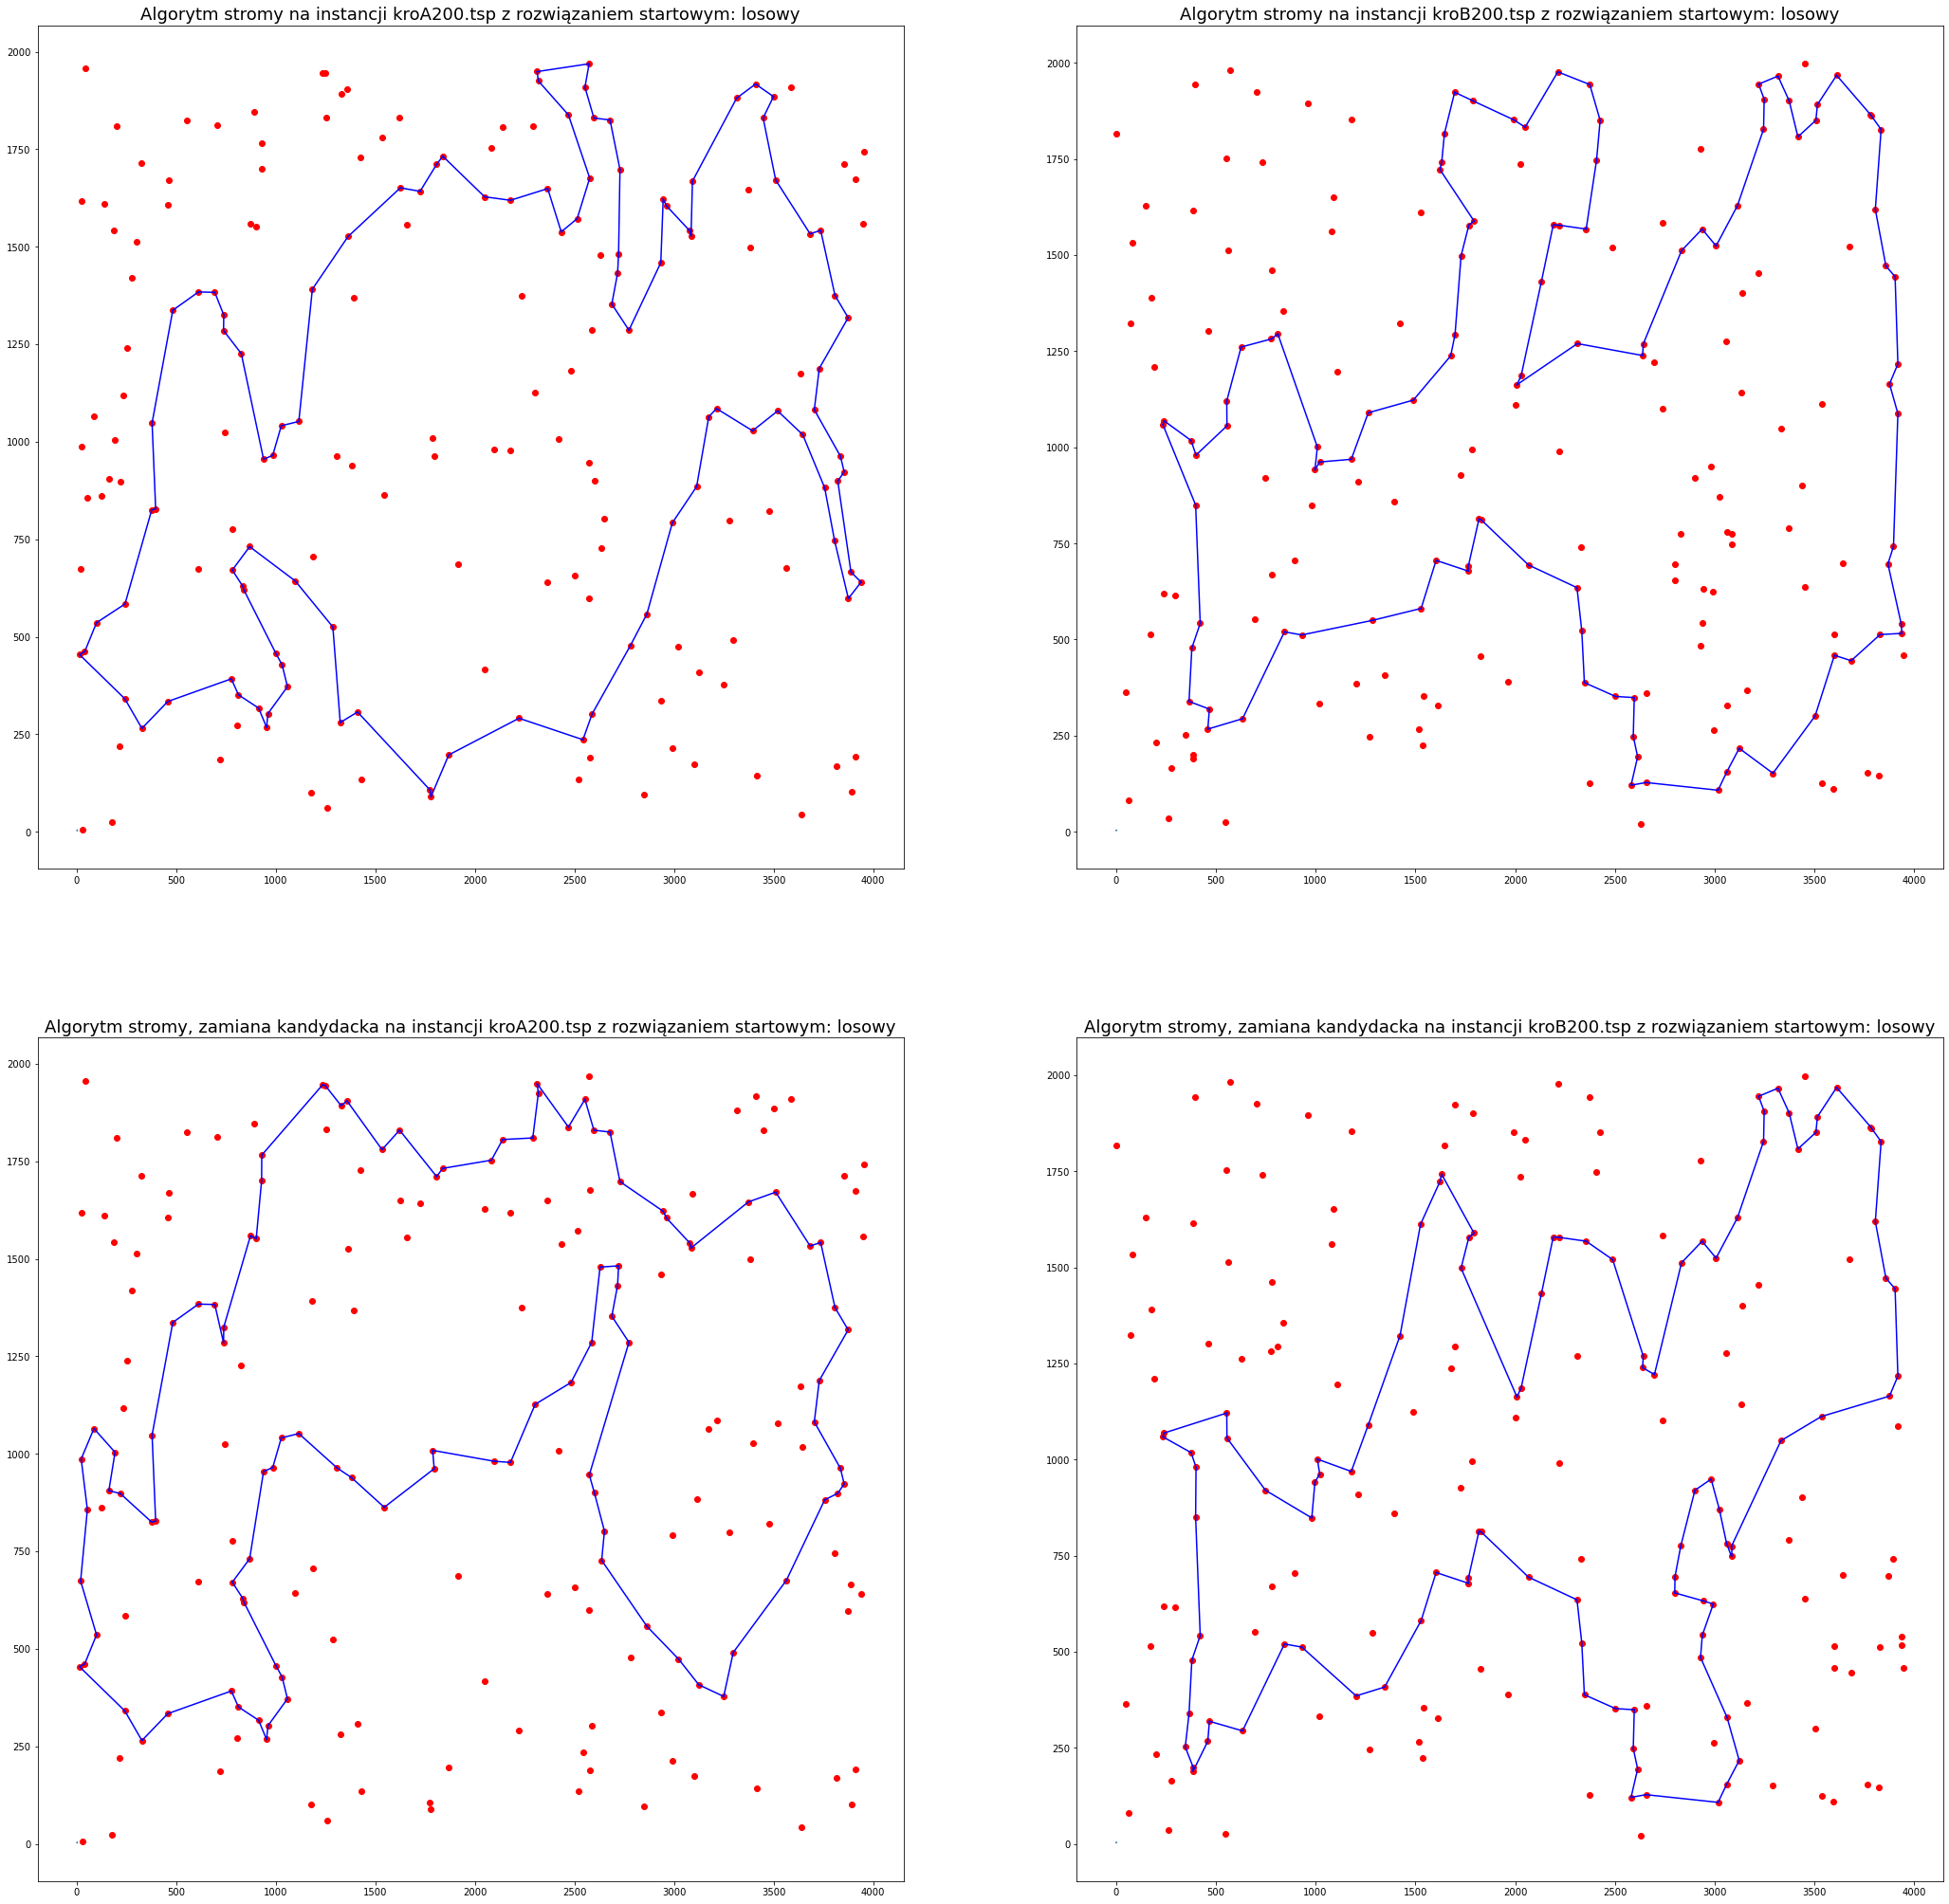

In [32]:
def print_map(res, path, ax):
    ax.plot([1,2], [3,4])
    ln=len(path)
    for x, v1 in enumerate(path):
        v2=path[(x+1)%ln]
        ax.plot([res[v1][1], res[v2][1]], [res[v1][2], res[v2][2]], color='blue')
    ax.scatter([x[1] for x in res], [x[2] for x in res], color='red')

mapp={'kroA200.tsp':0, 'kroB200.tsp':1, 'steep':0, 
     'steep with candidates':1,
     'random':0, '2reg-2':1}

naming={'steep':'stromy', 'steep with candidates': 'stromy, zamiana kandydacka',
       'random':'losowy', '2reg-2':'2-żal 2.0'}

all_solutions=len(reality)

for y in post_reality:
    typic=18
    plots=len(reality)
    fig, ax=plt.subplots(plots, 2, figsize=(2*typic, plots*typic))
    if plots==1:
        ax=[ax]
        
    for x in system:
        if x[1]!=y[0]:
            continue
        col=mapp[x[0]]
        row=mapp[x[2]]
        print_map(properties[x[0]]['res'], system[x]['path'], ax[row][col])
        ax[row][col].set_title(f'Algorytm {naming[x[2]]} na instancji {x[0]} z rozwiązaniem startowym: {naming[x[1]]}', size=18)
    plt.savefig(f"heury_{y[0]}.svg", bbox_inches="tight")

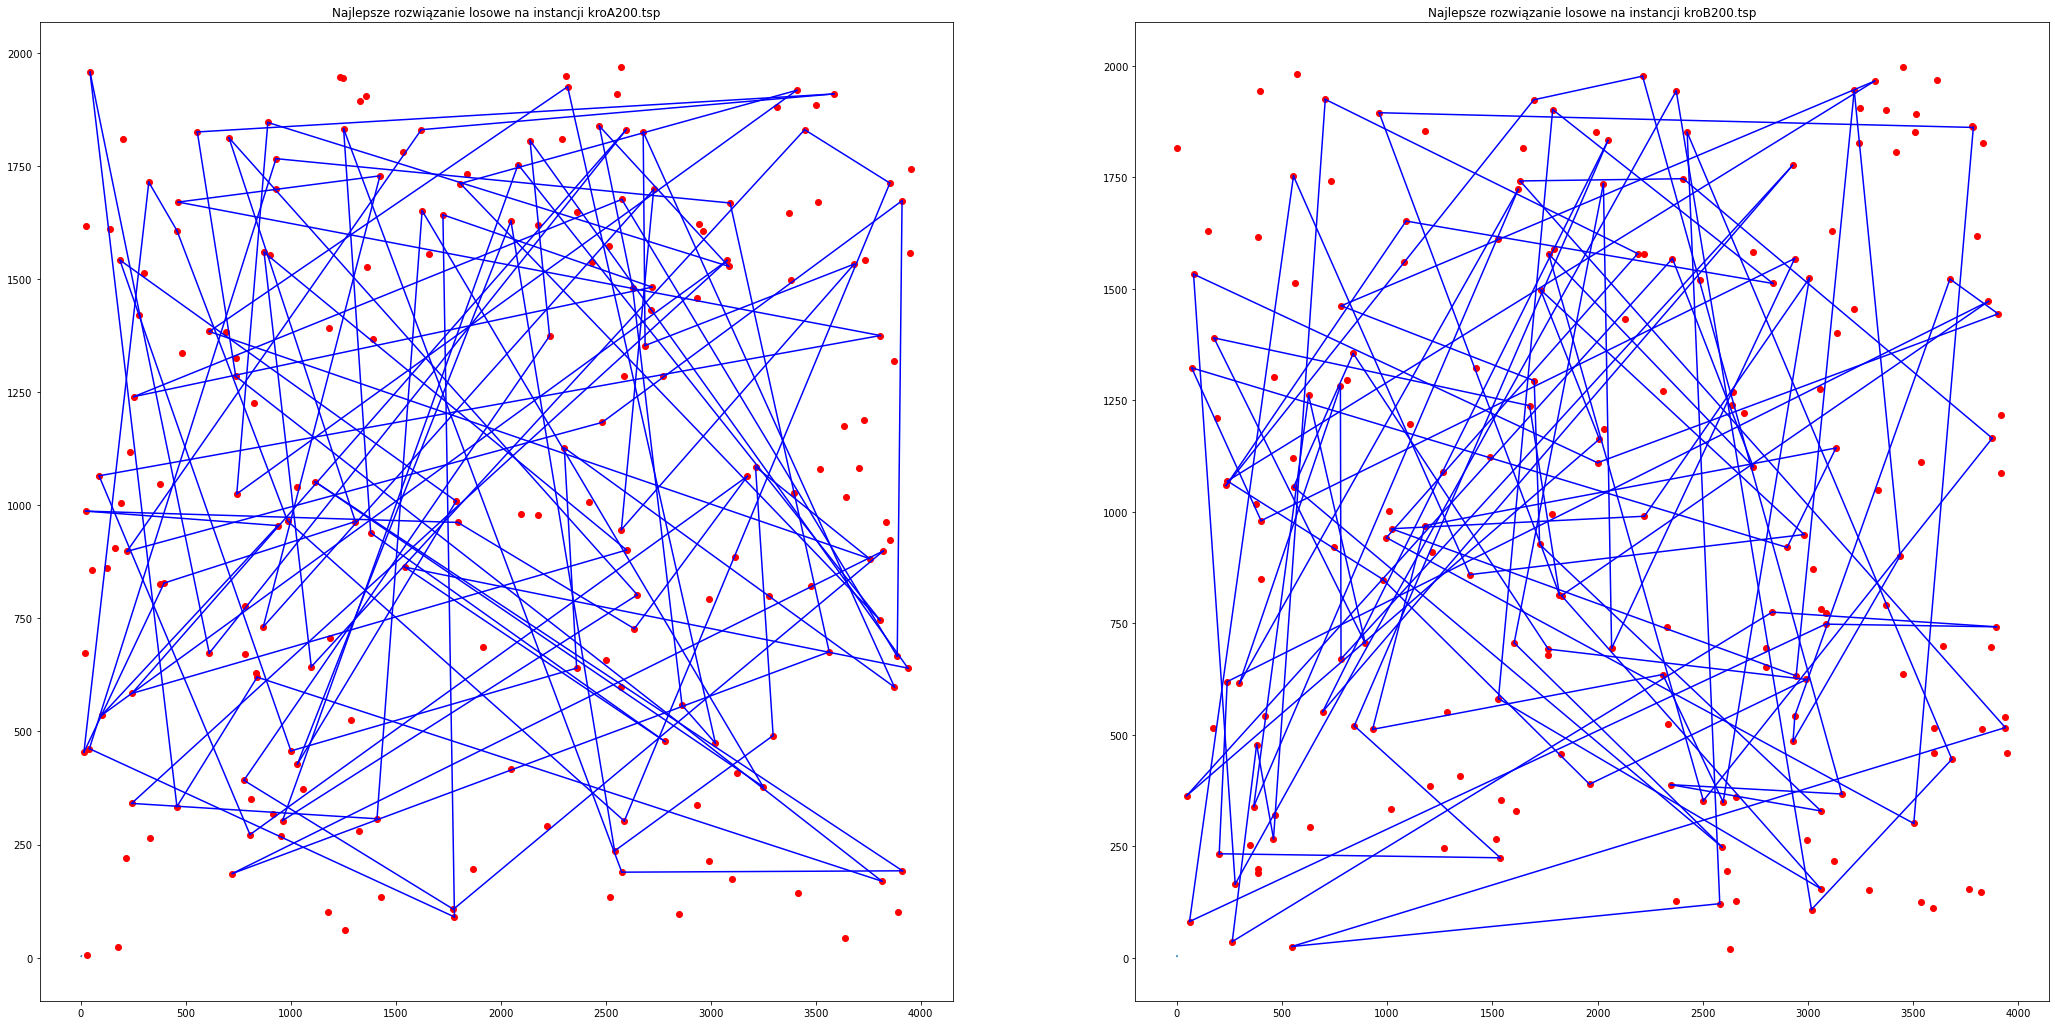

In [33]:
typic=18
fig, ax=plt.subplots(1, 2, figsize=(2*typic, typic))
for i, x in enumerate(properties):
    print_map(properties[x]['res'], properties[x]['bare_path'].pathway, ax[i])
    ax[i].set_title(f'Najlepsze rozwiązanie losowe na instancji {x}')
plt.savefig(f"bieda_heury.svg")

In [34]:
neo_naming={
    'steep':('stromy', 'żadna'), 'steep with candidates':('stromy', 'kandydacka'), 
}

for x in system:
    print(f'{x[0]} & {neo_naming[x[2]][0]} & {neo_naming[x[2]][1]} & {naming[x[1]]}', end='')
    for y in system[x]:
        if y!='path':
            print(f' & {system[x][y]:.2f}', end='')
    print('\\\\ \\hline')

kroA200.tsp & stromy & żadna & losowy & 14349.00 & 16280.00 & 15108.80 & 2.59 & 3.15 & 2.83\\ \hline
kroA200.tsp & stromy & kandydacka & losowy & 13426.00 & 16671.00 & 14984.60 & 0.27 & 0.34 & 0.30\\ \hline
kroB200.tsp & stromy & żadna & losowy & 13896.00 & 15688.00 & 14708.00 & 2.51 & 3.02 & 2.75\\ \hline
kroB200.tsp & stromy & kandydacka & losowy & 13596.00 & 16501.00 & 14787.40 & 0.26 & 0.36 & 0.31\\ \hline


In [6]:
print(system_starter)

{('kroA100.tsp', 'random'): {'min_res': 73315, 'max_res': 87977, 'avg_res': 2472.17}, ('kroA100.tsp', '2reg-2'): {'min_res': 10450, 'max_res': 10450, 'avg_res': 209.0}, ('kroB100.tsp', 'random'): {'min_res': 76989, 'max_res': 88371, 'avg_res': 1653.6}, ('kroB100.tsp', '2reg-2'): {'min_res': 9629, 'max_res': 9629, 'avg_res': 192.58}}


In [8]:
import heapq

h = []
heapq.heappush(h, (5, {'a':['write code', "BENIZZII"], 'b':312}))
heapq.heappush(h, (7, 'release product'))
heapq.heappush(h, (1, 'write spec'))
heapq.heappush(h, (3, 'create tests'))
falka=heapq.heappop(h)
print(h, falka)

[(3, 'create tests'), (7, 'release product'), (5, {'a': ['write code', 'BENIZZII'], 'b': 312})] (1, 'write spec')
